# Librerías y configuración

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Lectura de datos 

In [3]:
df = pd.read_excel('Data/AllMetrics.xlsx')
df.head()

,Unnamed: 0,Scopus author ID,Most recent publication,Citations,Citations per Publication,Field-Weighted Citation Impact,h-index,Output in Top 10% Citation Percentiles (field-weighted),Oldest publication (since 1996),CiteScore,SNIP,h-index Ponderado
0,0,10038895100,2017,36,36.0,2.13,1,12.0,2017,7.4,1.45,1.0
1,1,10039007800,2018,24,24.0,3.10,1,7.0,2018,3.5,1.19,1.0
2,2,10039013100,2020,0,0.0,0.00,0,71.0,2020,2.6,1.00,0.0
3,3,10039034400,2019,25,25.0,3.72,1,5.0,2019,2.7,0.88,1.0
4,4,10039108900,2021,6,6.0,1.63,1,18.0,2021,16.8,2.29,1.0


In [4]:
df['Career years'] = df['Most recent publication'] - df['Oldest publication (since 1996)'] + 1

cols = ['Unnamed: 0','Most recent publication','Oldest publication (since 1996)']
df.drop(columns=cols,inplace=True)
df.set_index('Scopus author ID',inplace=True)
df.head()

,Citations,Citations per Publication,Field-Weighted Citation Impact,h-index,Output in Top 10% Citation Percentiles (field-weighted),CiteScore,SNIP,h-index Ponderado,Career years
Scopus author ID,,,,,,,,,
10038895100,36,36.0,2.13,1,12.0,7.4,1.45,1.0,1
10039007800,24,24.0,3.10,1,7.0,3.5,1.19,1.0,1
10039013100,0,0.0,0.00,0,71.0,2.6,1.00,0.0,1
10039034400,25,25.0,3.72,1,5.0,2.7,0.88,1.0,1
10039108900,6,6.0,1.63,1,18.0,16.8,2.29,1.0,1


# Entendimiento de los datos

Revisar multicolinealidad entre variables

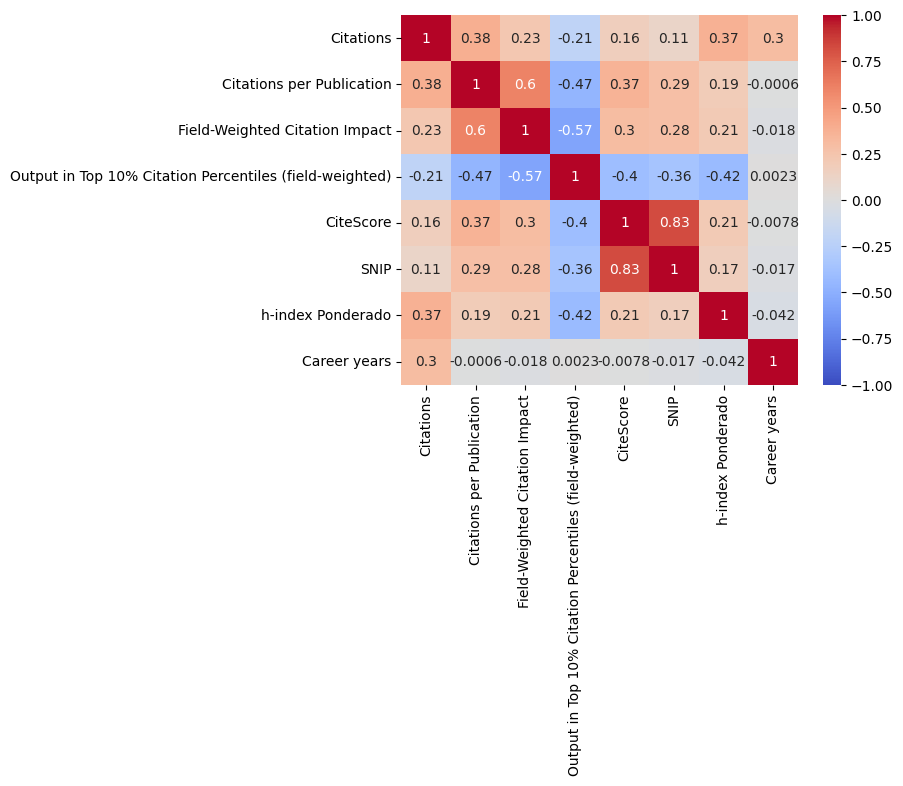

In [5]:
cols = ['Citations','Citations per Publication','Field-Weighted Citation Impact',
        'Output in Top 10% Citation Percentiles (field-weighted)',
        'CiteScore','SNIP','h-index Ponderado','Career years']
sns.heatmap(df[cols].corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm')
plt.show()

Por la correlación entre SNIP y CiteScore, se quitará una de las columnas para el análisis

In [6]:
df_ = df.drop(columns=['CiteScore'])

# Target h-index

Se elimina el h-index ponderado porque se calcula con el h-index que es el target

In [7]:
df1 = df_.drop(columns=['h-index Ponderado'])

## Partición de base de datos

In [8]:
target = ['h-index']
X = df1.drop(columns=target)
Y = df1[target]

## Regresión lineal Ordinary Least Squares (OLS)

In [9]:
Xc = sm.add_constant(X) #para obtener la ordenada en el origen
model = sm.OLS(Y, Xc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                h-index   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                 6.185e+04
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:49:12   Log-Likelihood:            -1.6759e+05
No. Observations:              136109   AIC:                         3.352e+05
Df Residuals:                  136102   BIC:                         3.353e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

El R² ajustado es medianamente bueno, pero el Jarque-Bera es demasiado alto, lo que indica que la distribución de los errores no es normal.

## Regresión lineal con sklearn

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.30,random_state=0)

model = LinearRegression()
model.fit(X_train,Y_train)
print('Intercept',model.intercept_[0])
for i in range(len(X_train.columns)):
    print(X_train.columns[i],model.coef_[0][i])

Intercept 1.0545548794962698
Citations 0.014321796073577258
Citations per Publication -0.01947261523997112
Field-Weighted Citation Impact -0.024964535806106396
Output in Top 10% Citation Percentiles (field-weighted) -0.015356948586858793
SNIP 0.011420263433314978
Career years 0.5437220683544697


In [11]:
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,Y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,Y_test)))
print('MAE',mean_absolute_error(Y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(Y_test, predictions))  #mean squared error


Puntaje entrenamiento: 0.767013714027356

Puntaje Test: 0.5793964871081672

MAE 0.5056983752005062
MSE 1.1508243056021663


El modelo se ajusta moderadamente para el conjunto de entrenamiento, pero no para el de prueba, puede que haya overfitting

## Regresión polinomial OLS

In [13]:
polynomial_features= PolynomialFeatures(degree=3)
Xp = polynomial_features.fit_transform(X)
Xpc = sm.add_constant(Xp) #para obtener la ordenada en el origen
model = sm.OLS(Y, Xpc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                h-index   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 1.648e+04
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:49:49   Log-Likelihood:                -93576.
No. Observations:              136109   AIC:                         1.873e+05
Df Residuals:                  136025   BIC:                         1.881e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1445      0.062      2.345      0.0

## Regresión polinomial con sklearn

In [14]:
Xp_train,Xp_test,Yp_train,Yp_test = train_test_split(Xp,Y,test_size=.30,random_state=0)

model = LinearRegression()  
model.fit(Xp_train,Yp_train)  
predictions = model.predict(Xp_test)
print('Puntaje entrenamiento: {}\n'.format(model.score(Xp_train,Yp_train)))
print('Puntaje Test: {}\n'.format(model.score(Xp_test,Yp_test)))
print('MAE',mean_absolute_error(Yp_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(Yp_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.9111567377797642

Puntaje Test: -63.93894397669351

MAE 0.39835979055790843
MSE 177.68114820223943


## Regresión con kNN

In [15]:
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(transformed_X,Y,test_size=.30,random_state=0)

model = KNeighborsRegressor(5,metric='euclidean')  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.9616907063377383

Puntaje Test: 0.9280686105345095

MAE 0.16763891950138368
MSE 0.19681336174172853


## Regresión con Árbol de decisión

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.30,random_state=0)

model = DecisionTreeRegressor(max_depth=3)  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.7805979322859058

Puntaje Test: 0.7419143205255472

MAE 0.35990657171497403
MSE 0.7061549981477049


## Regresión con Random Forest

In [17]:
model = RandomForestRegressor(max_depth=10,max_leaf_nodes=50,random_state=0)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
print('MAE:',mean_absolute_error(y_test, predictions))
print('train score',model.score(X_train,y_train))
print('test score',model.score(X_test,y_test))

/tmp/ipykernel_27899/3934460837.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


MAE: 0.17930466657135913
train score 0.9406165891091047
test score 0.9235355359136694


# Target h-index ponderado

Se elimina el h-index porque este calcula el h-index ponderado

In [18]:
df2 = df_.drop(columns=['h-index'])

## Partición de base de datos

In [19]:
target = ['h-index Ponderado']
X = df2.drop(columns=target)
Y = df2[target]

## Regresión lineal Ordinary Least Squares (OLS)

In [20]:
Xc = sm.add_constant(X) #para obtener la ordenada en el origen
model = sm.OLS(Y, Xc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      h-index Ponderado   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     9720.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:50:04   Log-Likelihood:                -78546.
No. Observations:              136109   AIC:                         1.571e+05
Df Residuals:                  136102   BIC:                         1.572e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

El R² ajustado es muy bajo, por lo que el modelo no predice bien los valores

## Regresión lineal con sklearn

In [21]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.30,random_state=0)

model = LinearRegression()
model.fit(X_train,Y_train)
print('Intercept',model.intercept_[0])
for i in range(len(X_train.columns)):
    print(X_train.columns[i],model.coef_[0][i])

Intercept 1.4607710327229917
Citations 0.0032701601918303062
Citations per Publication -0.004536503549201019
Field-Weighted Citation Impact -0.016483102088435588
Output in Top 10% Citation Percentiles (field-weighted) -0.011228628474708723
SNIP 0.010337176489985805
Career years -0.08101034822181241


In [22]:
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,Y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,Y_test)))
print('MAE',mean_absolute_error(Y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(Y_test, predictions))  #mean squared error


Puntaje entrenamiento: 0.3177257256037209

Puntaje Test: 0.21330150761841138

MAE 0.30577894843323494
MSE 0.2140538532206862


El R² ajustado es muy bajo, por lo que el modelo no predice bien los valores

## Regresión polinomial OLS

In [23]:
polynomial_features= PolynomialFeatures(degree=3)
Xp = polynomial_features.fit_transform(X)
Xpc = sm.add_constant(Xp) #para obtener la ordenada en el origen
model = sm.OLS(Y, Xpc) #Ordinary Least Squares
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      h-index Ponderado   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     4188.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:50:07   Log-Likelihood:                -16486.
No. Observations:              136109   AIC:                         3.314e+04
Df Residuals:                  136025   BIC:                         3.397e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5932      0.035     45.556      0.0

## Regresión polinomial con sklearn

In [24]:
Xp_train,Xp_test,Yp_train,Yp_test = train_test_split(Xp,Y,test_size=.30,random_state=0)

model = LinearRegression()  
model.fit(Xp_train,Yp_train)  
predictions = model.predict(Xp_test)
print('Puntaje entrenamiento: {}\n'.format(model.score(Xp_train,Yp_train)))
print('Puntaje Test: {}\n'.format(model.score(Xp_test,Yp_test)))
print('MAE',mean_absolute_error(Yp_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(Yp_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.7191030294637757

Puntaje Test: -37.23867964876551

MAE 0.20501398263863552
MSE 10.404413889380493


## Regresión con kNN

In [25]:
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(transformed_X,Y,test_size=.30,random_state=0)

model = KNeighborsRegressor(5,metric='euclidean')  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.9242123886466234

Puntaje Test: 0.8740616296276025

MAE 0.06837582347611
MSE 0.034266740952987366


## Regresión con Árbol de decisión

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.30,random_state=0)

model = DecisionTreeRegressor(max_depth=3)  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.5873919330972488

Puntaje Test: 0.5835380422169889

MAE 0.1748239050454801
MSE 0.11331569546220042


## Regresión con Random Forest

In [27]:
model = RandomForestRegressor(max_depth=10,max_leaf_nodes=50,random_state=0)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
print('MAE:',mean_absolute_error(y_test, predictions))
print('train score',model.score(X_train,y_train))
print('test score',model.score(X_test,y_test))

/tmp/ipykernel_27899/3934460837.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


MAE: 0.07117554228603873
train score 0.9003293891199079
test score 0.890971034297355
